## Kommen Erstgeborene später zur Welt?

Oft hört man, dass erstgeborene Babies später zur Welt kommen als folgende Babies. Bei meinen eigenen Söhnen war das auch so. 
Aber gibt es da tatsächlichen einen Effekt? Und wenn ja, wie groß ist er?



Der folgende Code stammt aus dem Buch [Think Stats](https://greenteapress.com/thinkstats2). Er lädt einen Datensatz der [National Survey of Family Growth (NSFG)](http://cdc.gov/nchs/nsfg.htm) mit statistischen Informationen zu Schwangerschaften in den USA.

In [1]:
from __future__ import print_function
import numpy as np
import thinkstats2
import thinkplot

In [2]:
def CleanFemPreg(df):
    """Recodes variables from the pregnancy frame.
    df: DataFrame
    """
    # mother's age is encoded in centiyears; convert to years
    df.agepreg /= 100.0

    # birthwgt_lb contains at least one bogus value (51 lbs)
    # replace with NaN
    df.loc[df.birthwgt_lb > 20, 'birthwgt_lb'] = np.nan
    
    # replace 'not ascertained', 'refused', 'don't know' with NaN
    na_vals = [97, 98, 99]
    df.birthwgt_lb.replace(na_vals, np.nan, inplace=True)
    df.birthwgt_oz.replace(na_vals, np.nan, inplace=True)
    df.hpagelb.replace(na_vals, np.nan, inplace=True)

    df.babysex.replace([7, 9], np.nan, inplace=True)
    df.nbrnaliv.replace([9], np.nan, inplace=True)

    # birthweight is stored in two columns, lbs and oz.
    # convert to a single column in lb
    # NOTE: creating a new column requires dictionary syntax,
    # not attribute assignment (like df.totalwgt_lb)
    df['totalwgt_lb'] = df.birthwgt_lb + df.birthwgt_oz / 16.0    

    # due to a bug in ReadStataDct, the last variable gets clipped;
    # so for now set it to NaN
    df.cmintvw = np.nan

In [4]:
def ReadFemPreg(dct_file='2002FemPreg.dct',
                dat_file='2002FemPreg.dat.gz'):
    """Reads the NSFG pregnancy data.
    dct_file: string file name
    dat_file: string file name
    returns: DataFrame
    """
    dct = thinkstats2.ReadStataDct(dct_file)
    df = dct.ReadFixedWidth(dat_file, compression='gzip')
    CleanFemPreg(df)
    return df

In [5]:
def MakeFrames():
    """Reads pregnancy data and partitions first babies and others.
    returns: DataFrames (all live births, first babies, others)
    """
    preg = ReadFemPreg()

    live = preg[preg.outcome == 1]
    firsts = live[live.birthord == 1]
    others = live[live.birthord != 1]

    assert len(live) == 9148
    assert len(firsts) == 4413
    assert len(others) == 4735

    return live, firsts, others

Die folgende Zelle lädt die Datensätze zu Lebendgeburten insgesamt sowie Erstgeburten und Folgegeburten.

In [6]:
live, firsts, others = MakeFrames()

Das Feld `prglngth` enthält dabei die Länge der Schwangerschaft in Wochen.

In [7]:
len(live), len(firsts)

(9148, 4413)

## Aufgabe: Untersuchung der Daten

Untersuchen Sie die geladenen Daten:

- Wie ist die durchschnittliche Länge einer ersten bzw. folgenden Schwangerschaft?
- Wie hoch ist die Varianz der Schwangerschaftslänge?

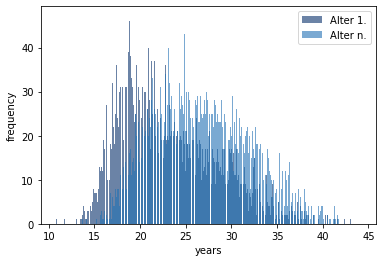

<Figure size 576x432 with 0 Axes>

In [17]:
first_hist = thinkstats2.Hist(firsts.agepreg, label='Alter 1.')
other_hist = thinkstats2.Hist(others.agepreg, label='Alter n.')
thinkplot.Hist(first_hist)
thinkplot.Hist(other_hist)
thinkplot.Show(xlabel='years', ylabel='frequency')

## Z-Test und t-Test für die Signifikanz der Abweichung des Mittelwerts

In [9]:
import math
import random

In [24]:
np.mean(firsts.totalwgt_lb), np.mean(others.totalwgt_lb)

(7.201094430437772, 7.325855614973262)

In [19]:
diff = abs(np.mean(firsts.agepreg.values) - np.mean(others.agepreg.values))
diff

3.5864347661500275

In [21]:
count = 0
N = 10000
all = np.hstack((firsts.agepreg.values, others.agepreg.values))
for i in range(N):
    np.random.shuffle(all)
    _diff = abs(np.mean(all[:len(firsts.agepreg)]) - np.mean(all[len(firsts.agepreg):]))
    if _diff > diff:
        count += 1
count / N

0.0

In [13]:
len(firsts), len(others)

(4413, 4735)

In [25]:
np.mean(firsts.totalwgt_lb), np.mean(others.totalwgt_lb)

(7.201094430437772, 7.325855614973262)

In [26]:
np.var(firsts.totalwgt_lb), np.var(others.totalwgt_lb)

(2.0175647688734033, 1.9433652438588467)

###### Z = (np.mean(firsts.prglngth) - np.mean(live.prglngth)) / (np.var(live.prglngth) / math.sqrt(len(firsts)))
Z

In [27]:
t = math.sqrt(len(firsts)*len(others) / (len(firsts) + len(others))) * (np.mean(firsts.prglngth) - np.mean(others.prglngth)) / np.var(live.prglngth) 
t

1.4044107243660564